In [ ]:
import pandas as pd
import sqlite3

In [ ]:
fname = "/kaggle/input/worlds-real-estate-data147k/world_real_estate_data(147k).csv"

In [ ]:
# Read CSV file into a Pandas DataFrame
csv_file = "/kaggle/input/worlds-real-estate-data147k/world_real_estate_data(147k).csv"
df = pd.read_csv(csv_file)

# Data Exploration

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
df.apartment_total_area

In [ ]:
df.apartment_total_area.isnull().sum()

how many rows with missing values ?

In [ ]:
df.isnull().sum()

In [ ]:
df.location.head()

In [ ]:
df.title.head()

In [ ]:
df.country.head()

In [ ]:
df.apartment_living_area

In [ ]:
df.apartment_bathrooms.value_counts()

In [ ]:
df.apartment_bedrooms.value_counts()

In [ ]:
df.apartment_rooms.value_counts()

In [ ]:
df.loc[(df.apartment_rooms.isnull() == False) ].loc[ (df.apartment_bedrooms.isnull() == False)][['apartment_rooms', 'apartment_bedrooms', 'apartment_bathrooms']]

We notice that **apartment_bedrooms** is almost always equal to **apartment_rooms** - 1

And that **apartment_bathrooms** and **apartment_bedrooms** doesn't necessarily sum up to **apartment_rooms**

In [ ]:
df.building_total_floors.value_counts().min()

In [ ]:
df.apartment_floor.value_counts().min()

I assume mising values for **building_total_floors** and **apartment_floor** are equal to 0

In [ ]:
df.building_construction_year

# Data Cleaning

We can notice that the field **apartment_total_area** contains string values, it would be more usefull to have it as a numerical field, n order to apply arithmetic ops on it

Also there is 5740 None values, it is not too much compared to 147536. On the other hand, I there is no way I can get their actual values, so I decide to remove them

In [ ]:
# Step 1: Remove None values in apartment_total_area from the df
df.dropna(subset=['apartment_total_area'], inplace = True)

In [ ]:
df.apartment_total_area.isnull().sum()

In [ ]:
# Step 2: Remove 'm²' from the column
df['apartment_total_area'] = df['apartment_total_area'].str.replace('m²', '')

In [ ]:
# Step 3: Remove space from the column
df['apartment_total_area'] = df['apartment_total_area'].str.replace(' ', '')

In [ ]:
# Step 4: Convert the column to numeric
df['apartment_total_area'] = pd.to_numeric(df['apartment_total_area'])

In [ ]:
df['apartment_total_area']

Deelete missing values

In [ ]:
df.isnull().sum()

In [ ]:
df.dropna(subset=['location', 'country', 'price_in_USD'], inplace = True)

In [ ]:
df.isnull().sum()

In [ ]:
df.loc[df.apartment_rooms.isnull() == False][['apartment_rooms', 'apartment_bedrooms', 'apartment_bathrooms']]

Given that I don't have another way to determine the exact number bathrooms. For this test scenario I choose to replace missing values for apartment_bathrooms with the weighted average

Replace missing values in **apartment_bathrooms** with weighted avg

In [ ]:
# Calculate frequency of each value
frequency = df["apartment_bathrooms"].value_counts()

# Calculate the weighted average
avg_w_bath = (frequency.index * frequency).sum() / frequency.sum()
avg_w_bath = int(avg_w_bath)

In [ ]:
avg_w_bath

In [ ]:
df.loc[df.apartment_bathrooms.isna(), 'apartment_bathrooms'] = avg_w_bath

Replace missing values for columns with a lot elements

In [ ]:
# Replace NaN in 'apartment_bedrooms' with 1 when 'apartment_rooms' is 1
df.loc[(df['apartment_rooms'] == 1) & (df['apartment_bedrooms'].isna()), 'apartment_bedrooms'] = 1

In [ ]:
# Replace NaN in 'apartment_bedrooms' with 'apartment_rooms - 1' when 'apartment_rooms' > 1
df.loc[(df['apartment_rooms'] > 1) & (df['apartment_bedrooms'].isna()), 'apartment_bedrooms'] = (df['apartment_rooms'] - 1)

In [ ]:
df.loc[(df['apartment_bedrooms'] >= 1) & (df['apartment_rooms'].isna()), 'apartment_rooms'] = (df['apartment_bedrooms'] + 1)

In [ ]:
df.isnull().sum()

Now that we were able to recover 50k **apartment_bedrooms** and more than 10k **apartment_rooms** we will delete the rest of missing values in those 2 columns

In [ ]:
df.dropna(subset=['apartment_rooms', 'apartment_bedrooms'], inplace = True)

In [ ]:
df.isnull().sum()

In [ ]:
df.shape

Replace missing values building_total_floors with 0

In [ ]:
df.loc[(df['building_total_floors'].isna()), 'building_total_floors'] = 0

In [ ]:
df.loc[(df['apartment_floor'].isna()), 'apartment_floor'] = 0

In [ ]:
df.isnull().sum()

Optional: Save a copy of the cleaned data

In [ ]:
df.to_csv("realestate_clean.csv", index=False)

# Data Base Creation (Option 1: sqlite3)

In [ ]:
# Connect to SQLite database (or create a new one if it doesn't exist)
conn = sqlite3.connect("UseCasesDB.db")

# Write the DataFrame to a table in the database
df.to_sql("realEstate", conn, if_exists="replace", index=False)

# Sample Queries with sqlite3

In [ ]:
query = "SELECT apartment_rooms, apartment_bedrooms, apartment_bathrooms  FROM realEstate where price_in_USD < 300000"

# Execute the query and fetch the data into a Pandas DataFrame
result_df = pd.read_sql_query(query, conn)

# Display the result
print(result_df)

In [ ]:
query = """SELECT apartment_total_area FROM realEstate where apartment_total_area < 70"""

# Execute the query and fetch the data into a Pandas DataFrame
result_df = pd.read_sql_query(query, conn)

# Display the result
print(result_df)

Check if correct:

In [ ]:
result_df.max()

It is !

# Data Base Creation (Option 2: sqlalchemy)

In [ ]:
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine
from langchain_community.agent_toolkits import create_sql_agent
from langchain_openai import ChatOpenAI

In [ ]:
engine = create_engine("sqlite:///realestate.db")
df.to_sql("realestate", engine, index=False)
db = SQLDatabase(engine=engine)
print(db.dialect)
print(db.get_usable_table_names())

# Sample Queries with SQLalchemy

In [ ]:
# Close the connection
conn.close()

In [ ]:

db.run("SELECT apartment_total_area FROM realEstate where apartment_total_area < 70")

# Langchain Config (with sqlalchemy)

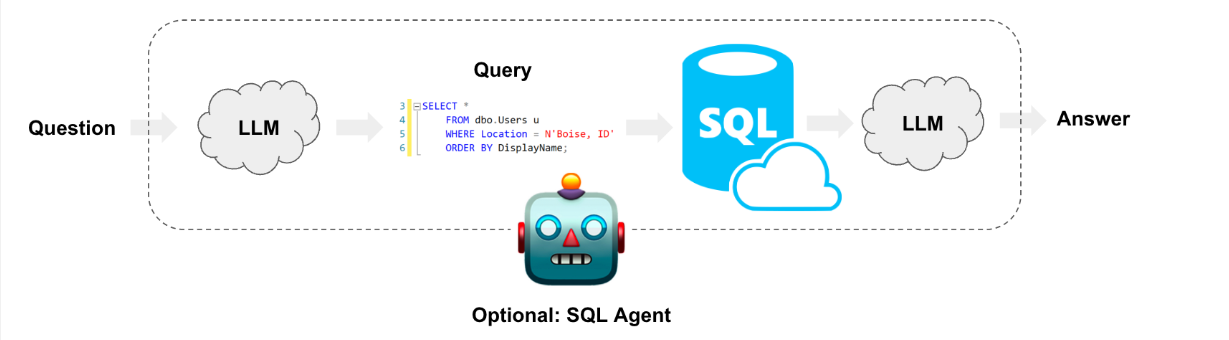

We'll be using sqlalchemy

In [ ]:
import os

# Load openAI key (in my case, it is stored safely with the Kaggle Secret Manager)
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("GPT_KEY")


os.environ["OPENAI_API_KEY"] = secret_value_0

In [ ]:
# instantiate a new llm (gpot)
llm = ChatOpenAI(model="gpt-4o", temperature=0)
# configure a new sql agent
agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=True)

In [ ]:
# Call the agent with an imput
agent_executor.invoke({"input": "what's the average price for appartements with 2 bedrooms"})